# Tutorial: Simulation of Information Diffusion in Social Networks 

Online Social Networks (OSNs) are ubiquitious in society and have in many ways transformed the very nature of human communication. They provide a unique opportunity to study human communication behavior and patterns. A particular phenomena of interest is "information diffusion" - that is, how does an idea spread throughout a network? Who are the key players that spread information? Can we predict how this information will continue spreading? 

We present a guide on information diffusion with two parts: 

   1. Building networks and understanding a basic epidemilogical model for information diffusion 
   2. Understanding basic predictive models, such as Linear Threshold and Linear Influence Mapping  

# Part 1: Random Networks & Epidemiological Diffusion 

## Introduction 

A cornerstone to understanding information diffusion is investigating different network structures. Because real social networks tend to be huge, random networks are often used in proxy of real data. The first random network was proposed by Erdos and Renyi in 1959. Since then, there has been significant progress in building models that feature more real-world properties. Social networks have two key properties: 
- Scale-Free 
- Community-Oriented 

Scale-Free means that the degrees do not follow any specific distribution; instead, certain nodes can have millions of connections. Community-Oriented means that there exist sub-"clusters" in the graph that have higher-than-average connectivity within the cluster than outside the cluster. 

Two of the leading social network models are the Baradasi-Albert model (which is scale-free) and the Watts-Strogatz network (which displays the clustering properties).

For our purposes, we're going to focus on the scale-free nature of networks. We will work through the following network types: 

1. Erdos-Renyi 
2. Stochastic Block Model 
3. Exponential Distributed Degrees 
4. Power-Law Distributed Degrees 
5. Baradasi-Albert Model 


### Setup 

Before getting started, we need to create the environment and set up some utility functions. This relies on the following non-standard packages: 
  * graph_tool 
  * NumPy 
  * Matplotlib 
  

In [1]:
import graph_tool as gt 
from graph_tool import generation, draw, Graph
import numpy as np
import os 
import copy
#Required to get matplotlib and graph-tool to play nice 
os.environ['KMP_DUPLICATE_LIB_OK']='True' 
import matplotlib.pyplot as plt 
%matplotlib inline 
import random 

l = 0.01 # vary between 0 (no connections) and 1 (all connected) 
n = 1000  # Number of Nodes 
c = 10 # Communities (SBM Only)

# Function used for community networks 
def group_mem_prob(a, b): 
    if a == b: 
        return 0.995 # Increase for tighter communities 
    else: 
        return 0.005 # increase for looser communities 

# Get graph positions using SFDP layouts with common parameters 
def get_positions(graph): 
    pos = draw.sfdp_layout(graph, mu = 1.0, mu_p = 1.0, 
                           gamma=5.0, C= 5.0, p=0.1, max_level=20)
    return pos 

# Draw graph with thin edges and certain properties 
# Optionally specify an output file 
# Must specify to_file=True to get it to work with saving to file.  
def draw_graph(graph, 
               pos = None, 
               to_file = False, 
               vertex_fill_color=None, 
               folder = "", 
               file="graph"): 
    degs = graph.degree_property_map("out")
    degs.a = 2 * np.sqrt(degs.a)
    if pos == None: 
        pos = get_positions(graph) 
    
    if folder != "": 
        path = folder + "/" + file + ".png" 
    else: 
        path = "./" + file + ".png"
    if to_file: 
        draw.graph_draw(graph, output = path, 
                  vertex_size = degs,
                  vertex_fill_color = vertex_fill_color, 
                  pos=pos, edge_color="black", edge_pen_width=0.08)
    else: 
        draw.graph_draw(graph, inline=True, 
            vertex_size = degs,
            vertex_fill_color = vertex_fill_color, 
            pos=pos, edge_color="black", edge_pen_width=0.08)

/Users/rajshrimali/anaconda3/lib/python3.7/site-packages/graph_tool/draw/cairo_draw.py:1494: RuntimeWarning: Error importing Gtk module: No module named 'gi'; GTK+ drawing will not work.
  warnings.warn(msg, RuntimeWarning)


### Erdos-Renyi Graph 

The Erdos-Renyi graph is the simplest of random graphs. For all nodes $n_i, n_j, 0 \le i, j \le N$, an edge is drawn between $n_i$ and $n_j$ with probability $p$. 

Graph-Tool has a convininent method for making a random graph in such a format. We set up our edge probability as a poisson distribution of (n - 1) (other nodes) * (l) (our probability) to get the "mean" degree, and specify the Erdos model for choosing partner nodes. 

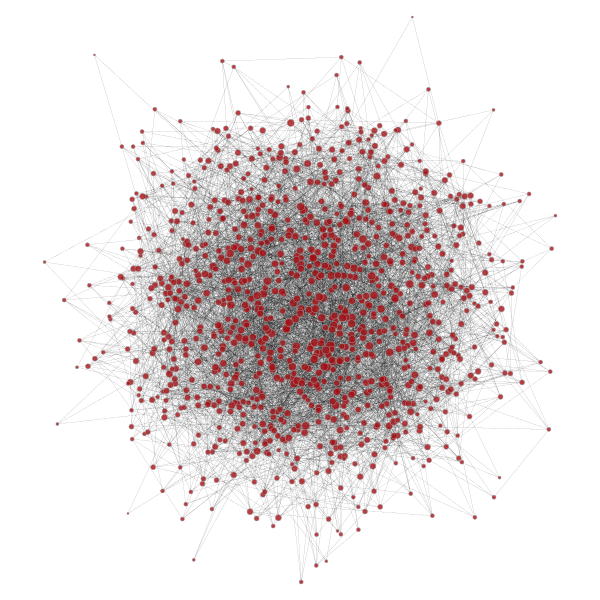

In [2]:
erdos_renyi = generation.random_graph(n, 
                                      lambda: np.random.poisson((n-1) * l), 
                                      directed=False, 
                                      model="erdos") 
draw_graph(erdos_renyi)

### Stochastic Block Model 

A Stochastic Block Model graph displays great community-like characteristics. graph-tool has a way to create these as well, with the parameter $c$ controlling the number of groups. 

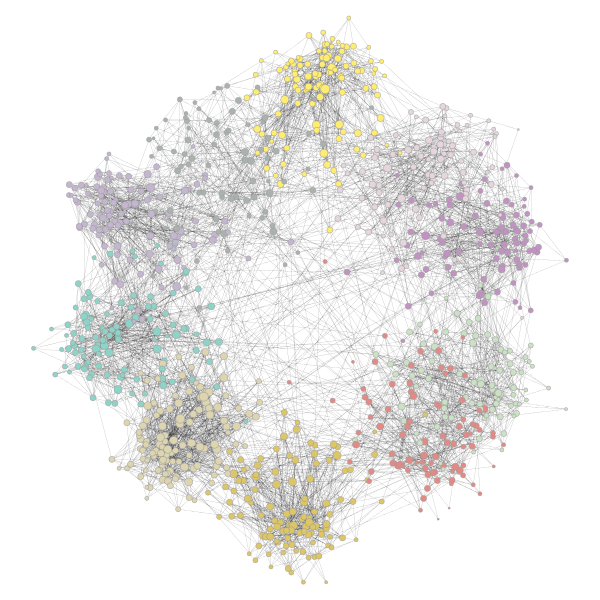

In [3]:
sbm, bm = generation.random_graph(n, lambda: np.random.poisson(c), 
                           directed = False, 
                           model="blockmodel", 
                           block_membership = lambda: np.random.randint(c), 
                           edge_probs = group_mem_prob)
draw_graph(sbm, vertex_fill_color=bm)

### Exponential and Power-Law Distributions 

These are simply created to exhibit a few nodes with a large number of connections, but most with very few. 

In [4]:
# Exponential Dist. of Degrees 

exp_graph = generation.random_graph(n, 
                lambda: int(np.random.exponential(1/(l))) + 1, 
                directed=False)
draw_graph(exp_graph)

In [5]:
# Real-Life networks are Power-Law distributed 
power_graph = generation.random_graph(n, 
                         lambda: int(n * (1 - np.random.power(4))) + 1, 
                         directed=False)
draw_graph(power_graph)

### Barabasi-Albert Model 

Graph-Tool contains a handy function, ```price_network``` (which is a generalization of Barabasi-Albert) to create a random network. We simply specify the parameter $n$ number of nodes and $m$, the degree of newly added verticies before rewiring. 

The degree-distribution of Barabasi-Albert will also follow a power-law model.

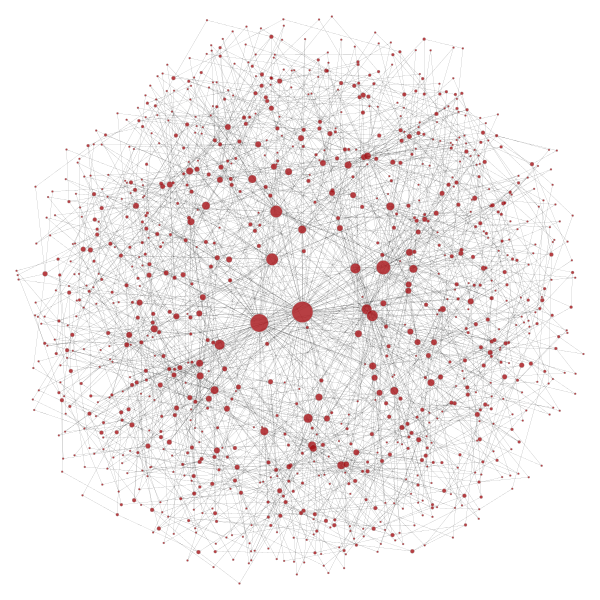

In [6]:
# Barabási–Albert is the go-to for this  
barabasi_albert = generation.price_network(n, m=2, directed=False)
draw_graph(barabasi_albert)

## Epidemiological Spreading

### Background 
A common way to think about information spreading in social networks is through epidemiological parallels. The information is modeled as a disease, and the disease spreads through the network. There are several different epidemiological models
Several Disease-Based Models 
 - SI (Susceptible-Infected) 
 - SIS (Susceptible-Infected-Susceptible) 
 - *SIR  (Susceptible-Infected-Recovered)*
 - **SIRS  (Susceptible-Infected-Recovered-Susceptible)**
 - SEIR (Susceptible-Exposed-Infected-Recovered)
 - S-SEIR 
 - SCIR 
 - irSIR 
 - FSIR 
 - ESIS 

This list is far from exhaustive. The italicized one, SIR, serves as the baseline for most of the more advanced models, while the bolded one, SIRS, is generally considered a more accurate representation of spreading. While the more advanced models each have their nuances tailored to information diffusion in OSNs, we focus on the basic SIRS model for simplicity and demonstrations' sake. 

The SIRS model has three variables. 

  * $s$ is the proportion of individuals susceptible to infection
  * $i$ is the proportion of individuals currently infected
  * $r$ is the proportion of individuals who have recovered and are now immune. 

The model is controlled by three parameters

  * $\lambda$ controls the rate of susceptible individuals becoming infected 
  * $\mu$ controls the rate of infected people recovering 
  * $\alpha$ controls the rate of recovered people becoming susceptible again. 

Note that $$s + i + r = 1$$ 

This proportion based model can easily be transformed into a numbers-based model by multiplying everything by $N$. 

To port this model over to a graph, we can do the following: 

For every node, 
1. If a patient is infected
  1. Go over their neighbors. Infect each neighbor with probability $\lambda$ 
  2. Recover them with probability $\mu$ 
2. If a patient is recovered, convert them to susceptible with probability $\alpha$ 


In [0]:
import random 
### BASIC SIRS SIMULATION ### 

# First, we create a copy of the graph we want to run simulations on
g = barabasi_albert.copy()
pos = get_positions(g)
# Set up infection variables 
lam = g.new_edge_property("double")  # it goes along edges
mu = g.new_vertex_property("double") # Vertex property because per individual 
a = g.new_vertex_property("double")  # Vertex Property because per individual 
state = g.new_vertex_property("vector<double>") # Keep track of S/I/R


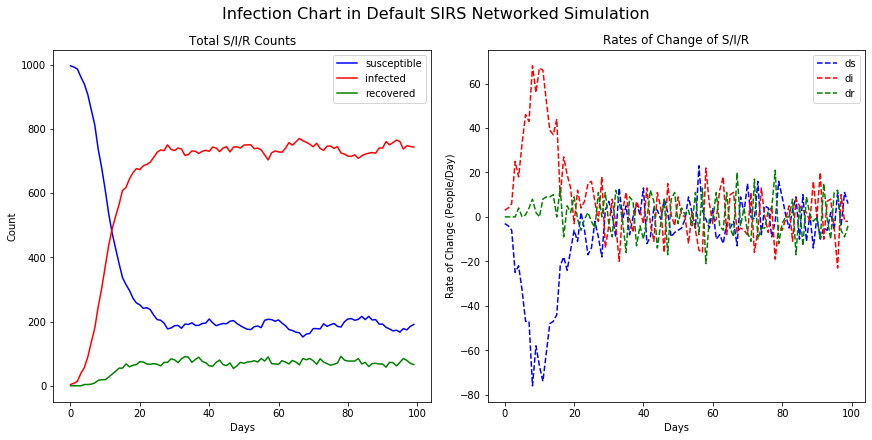

In [11]:

lam.a = 0.1  # Set lambda to 0.5 
mu.a = 0.05 # Recovery Rate to 0.05 
a.a = 0.5 # Recovered Users who become susceptible again 



def do_SIRS_simulation(g, PATIENT_ZEROS, state, lam, mu, a, pos, steps = 1000): 
    ''' 
    Resource: https://www.nature.com/articles/s41598-018-24648-w
    https://link.springer.com/chapter/10.1007/978-3-642-02466-5_78
    '''
    S = [1, 1, 1, 1] # Susceptible are white 
    I = [1, 0, 0, 1] # Infected are Red 
    R = [0.5, 0.5, 0.5, 1] # Recovered are Grey 

    # Set everyone to susceptible 
    for v in g.vertices(): 
        state[v] = S 

    # Infect Patients 0 
    for patient in PATIENT_ZEROS: 
        state[patient] = I

    vs = g.get_vertices()

    def step(): 
        # Keep track of new individuals in sets to keep changes atomic 
        new_infects = set() 
        new_recovers = set() 
        new_susceptibles = set() 

        for v in vs: 
            if state[v] == I: 
                # try to infect edges 
                for edge in g.get_out_edges(v): 
                    if state[edge[-1]] == S: #if they are susceptible... 
                        if random.random() < lam[g.edge(*edge)]: 
                            new_infects.add(edge[-1])
                # try to heal 
                if random.random() < mu[v]: 
                    new_recovers.add(v)
            # Recover people 
            if state[v] == R: 
                if random.random() < a[v]: 
                    new_susceptibles.add(v) 
        for v in new_infects: 
            state[v] = I 
        for v in new_recovers: 
            state[v] = R 
        for v in new_susceptibles: 
            state[v] = S 
        return new_susceptibles, new_infects, new_recovers 
  
    # Tracking code 
    counts = np.zeros((steps, 3)) 
    ds = []
    di = []
    dr = []
    for s in range(steps): 
        new_sus, new_inf, new_rec = step() 
        # Keep track of total counts 
        counts[s, 0] = sum(1 for v in g.get_vertices() if state[v] == S)
        counts[s, 1] = sum(1 for v in g.get_vertices() if state[v] == I)
        counts[s, 2] = sum(1 for v in g.get_vertices() if state[v] == R)
        # Calculate discrete-time differentials 
        ds.append(len(new_sus) - len(new_inf))
        di.append(len(new_inf) - len(new_rec))
        dr.append(len(new_rec) - len(new_sus))
    return counts, np.stack((ds, di, dr), axis=1)


counts, dcounts = do_SIRS_simulation(g, [0], state, lam, mu, a, pos, 100)

# Plot results 
fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, 
                               figsize=(12, 6), constrained_layout="True") 
x = list(range(100)) 
ax1.plot(x, counts[:, 0], 'b-', label="susceptible")
ax1.plot(x, counts[:, 1], 'r-', label="infected")
ax1.plot(x, counts[:, 2], 'g-', label="recovered")
ax1.legend();
ax2.plot(x, dcounts[:, 0], 'b--', label='ds')
ax2.plot(x, dcounts[:, 1], 'r--', label='di')
ax2.plot(x, dcounts[:, 2], 'g--', label="dr")
ax2.legend() 

fig.suptitle("Infection Chart in Default SIRS Networked Simulation", 
             fontsize=16)
ax1.set_title("Total S/I/R Counts") 
ax1.set_xlabel("Days") 
ax1.set_ylabel("Count") 

ax2.set_title("Rates of Change of S/I/R")
ax2.set_xlabel("Days") 
ax2.set_ylabel("Rate of Change (People/Day)");

### Modified SIRS 

We can easily introduce a slight twist to our model. Now, we modify the step() code. We create an "incubation time" - it takes a certain number of steps before infected individuals can be healed. In the results, we clearly see different behavior! 

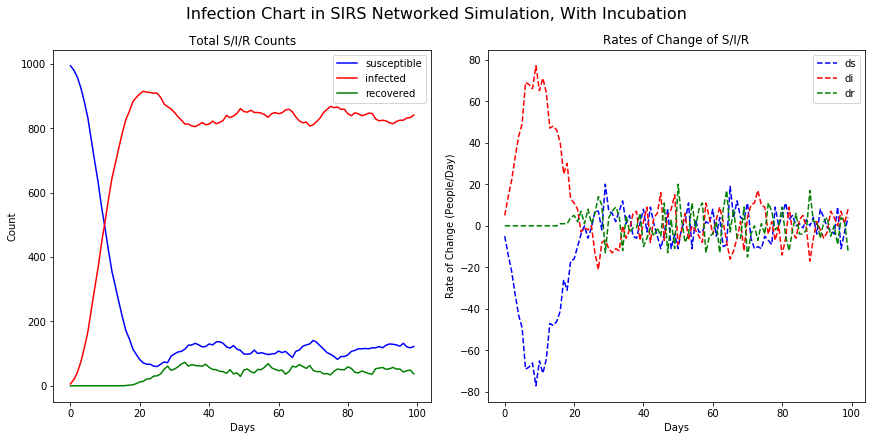

In [12]:
import os 
import random 
# Incubation Time version 
# can only heal after being undetected for certain number of timesteps 
lam.a = 0.1  # Set lambda to 0.5 
mu.a = 0.05 # Recovery Rate 
a.a = 0.5 # Recovered Users who become susceptible again 
INC_TIME = 14 # Incubation Time Step 

def do_incubation_simulation(g, PATIENT_ZEROS, state, lam, mu, a, pos, 
                             steps = 1000): 

    S = [1, 1, 1, 1] # Susceptible are white 
    I = [0, 0, 0, 1] # Infected are Black 
    R = [0.5, 0.5, 0.5, 1] # Recovered are Grey 

    # Set everyont to susceptible 
    for v in g.vertices(): 
        state[v] = S 

    inc_times= {} 

    # Infect Patients 0 
    for patient in PATIENT_ZEROS: 
        state[patient] = I
        inc_times[patient] = INC_TIME

    vs = g.get_vertices()
    def step(): 
        new_infects = set() 
        new_recovers = set() 
        new_susceptibles = set() 
        for v in vs: 
            if state[v] == I: 
                # try to infect edges 
                for edge in g.get_out_edges(v): 
                    if state[edge[-1]] == S: #if they are susceptible... 
                        if random.random() < lam[g.edge(*edge)]: 
                            new_infects.add(edge[-1])
                # try to heal 
                if inc_times[v] <= 0 and random.random() < mu[v]: 
                    new_recovers.add(v)
                inc_times[v] -= 1 
                
            # Recovered people might become susceptible.  
            if state[v] == R: 
                if random.random() < a[v]: 
                    new_susceptibles.add(v) 
        for v in new_infects: 
            inc_times[v] = INC_TIME 
            state[v] = I 
        for v in new_recovers: 
            state[v] = R 
        for v in new_susceptibles: 
            state[v] = S 
        return new_susceptibles, new_infects, new_recovers 
  
    counts = np.zeros((steps, 3)) 
    
    ds = []
    di = []
    dr = []
    for s in range(steps): 
        new_sus, new_inf, new_rec = step() 
        counts[s, 0] = sum(1 for v in g.get_vertices() if state[v] == S)
        counts[s, 1] = sum(1 for v in g.get_vertices() if state[v] == I)
        counts[s, 2] = sum(1 for v in g.get_vertices() if state[v] == R)
        ds.append(len(new_sus) - len(new_inf))
        di.append(len(new_inf) - len(new_rec))
        dr.append(len(new_rec) - len(new_sus))
    
    return counts, np.stack((ds, di, dr), axis=1)

counts, dcounts = do_incubation_simulation(g, [0], state, lam, mu, a, pos, 100)

fig, (ax1, ax2) = plt.subplots(nrows = 1, ncols = 2, 
                               figsize=(12, 6), constrained_layout="True") 
x = list(range(100)) 
ax1.plot(x, counts[:, 0], 'b-', label="susceptible")
ax1.plot(x, counts[:, 1], 'r-', label="infected")
ax1.plot(x, counts[:, 2], 'g-', label="recovered")
ax1.legend();
ax2.plot(x, dcounts[:, 0], 'b--', label='ds')
ax2.plot(x, dcounts[:, 1], 'r--', label='di')
ax2.plot(x, dcounts[:, 2], 'g--', label="dr")
ax2.legend() 

fig.suptitle("Infection Chart in SIRS Networked Simulation, With Incubation", 
             fontsize=16)
ax1.set_title("Total S/I/R Counts") 
ax1.set_xlabel("Days") 
ax1.set_ylabel("Count") 

ax2.set_title("Rates of Change of S/I/R")
ax2.set_xlabel("Days") 
ax2.set_ylabel("Rate of Change (People/Day)");

# Influence Models

# Predictive Models


In [0]:
g = barabasi_albert.copy()
activation_probs = g.new_edge_property("double")
activation_probs.set_value(0.35)

def independent_cascade(graph, seed_nodes, steps=0):
    """Returns the active nodes of each diffusion step by the independent cascade model

    Parameters
    ----------
    graph: graph_tool graph
    seed_nodes: list of nodes in the graph to start diffusion
    steps: integer for number of steps to run diffusion

    Returns
    -------
    layer_i_nodes: list of list of activated nodes
        layer_i_nodes[0]: seed_nodes
        layer_i_nodes[k]: nodes activated at kth diffusion step
    
    """
    
    for node in seed_nodes:
        if node not in graph.vertices():
            raise Exception(f"Seed node {node} not in graph")

    g = Graph(graph)
    g.set_directed(True)

    # run diffusion
    a = [s for s in seed_nodes]
    if steps <= 0:
        return _diffuse_all(g, a)
    return _diffuse_k_rounds(g, a, steps)

def _diffuse_all(g, a):
    tried_edges = set()
    layer_i_nodes = []
    layer_i_nodes.append([i for i in a])
    while True:
        len_old = len(a)
        a, activated_nodes, curr_tried_edges = _diffuse_one_round(g, a, tried_edges)
        layer_i_nodes.append(activated_nodes)
        tried_edges = tried_edges.union(curr_tried_edges)
        if len(a) == len_old:
            break
    return layer_i_nodes

def _diffuse_k_rounds(g, a, steps):
    tried_edges = set()
    layer_i_nodes = []
    layer_i_nodes.append([i for i in a])
    while steps > 0 and len(a) < len(g.nodes()):
        len_old = len(a)
        a, activated_nodes, curr_tried_edges = _diffuse_one_round(g, a, tried_edges)
        layer_i_nodes.append(activated_nodes)
        tried_edges = tried_edges.union(curr_tried_edges)
        if len(a) == len_old:
            break
        steps -= 1
    return layer_i_nodes

def _diffuse_one_round(g, a, tried_edges):
    activated_nodes = set()
    curr_tried_edges = set()
    for node in a:
        for nb in node.out_neighbors():
            if nb in a or (node, nb) in tried_edges or (node, nb) in curr_tried_edges:
                continue
            if _prop_success(g, node, nb):
                activated_nodes.add(nb)
            curr_tried_edges.add((node, nb))
    activated_nodes = list(activated_nodes)
    a.extend(activated_nodes)
    return a, activated_nodes, curr_tried_edges

def _prop_success(g, src, dest):
    edge = g.edge(src, dest)
    if edge is None:
        return False
    return random.random() <= activation_probs[edge]

In [0]:
num_seeds = 50

seed_nodes = random.choices([n for n in g.vertices()], k=num_seeds)
layer_i_nodes = independent_cascade(g, seed_nodes)

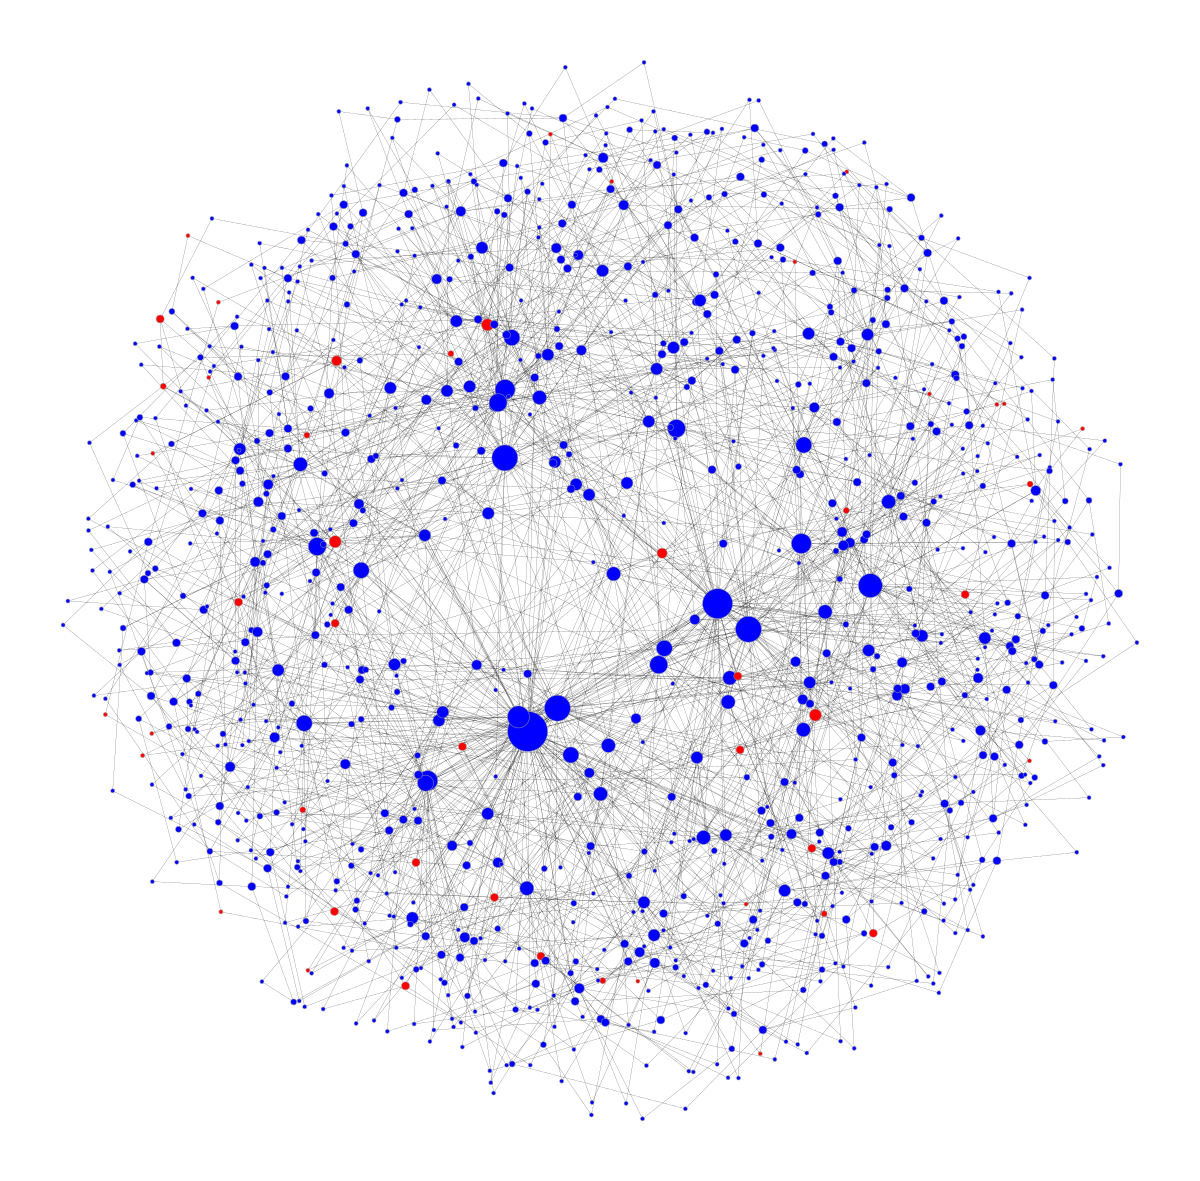

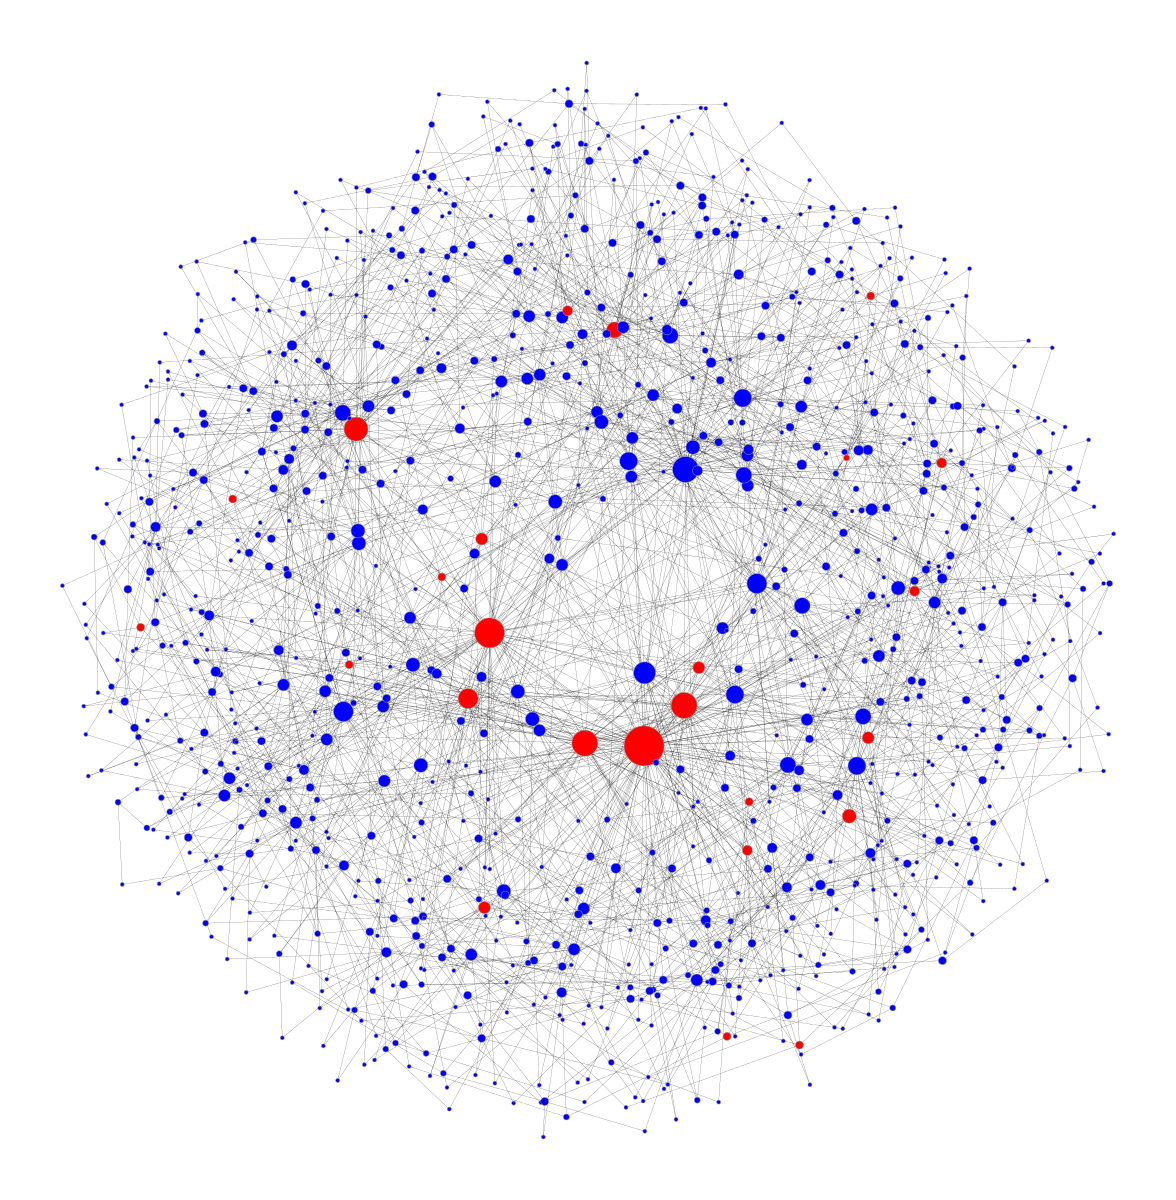

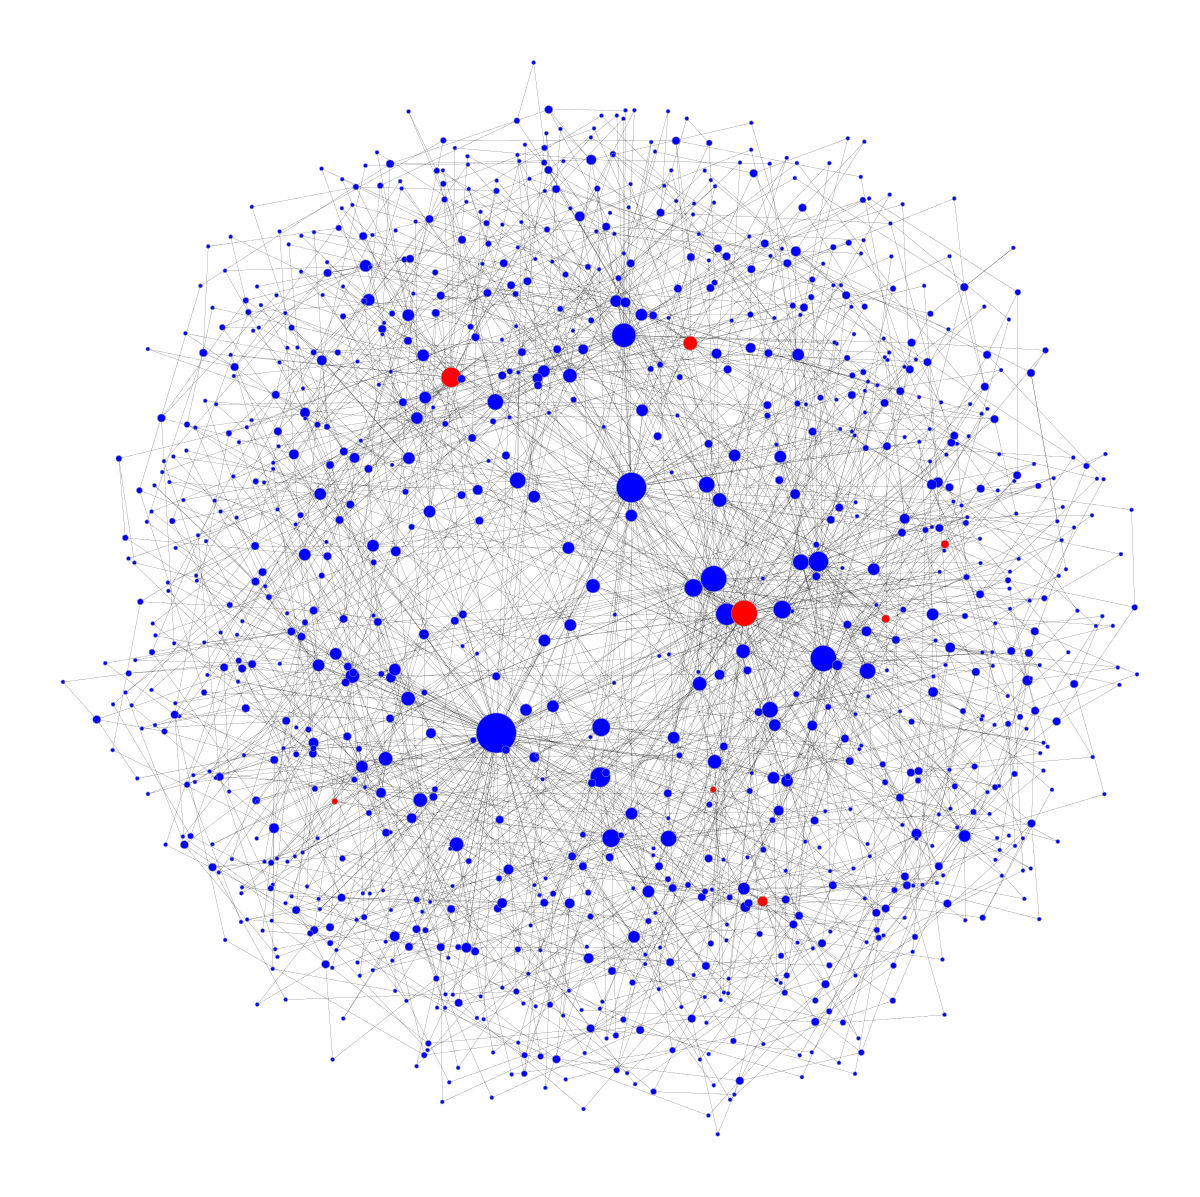

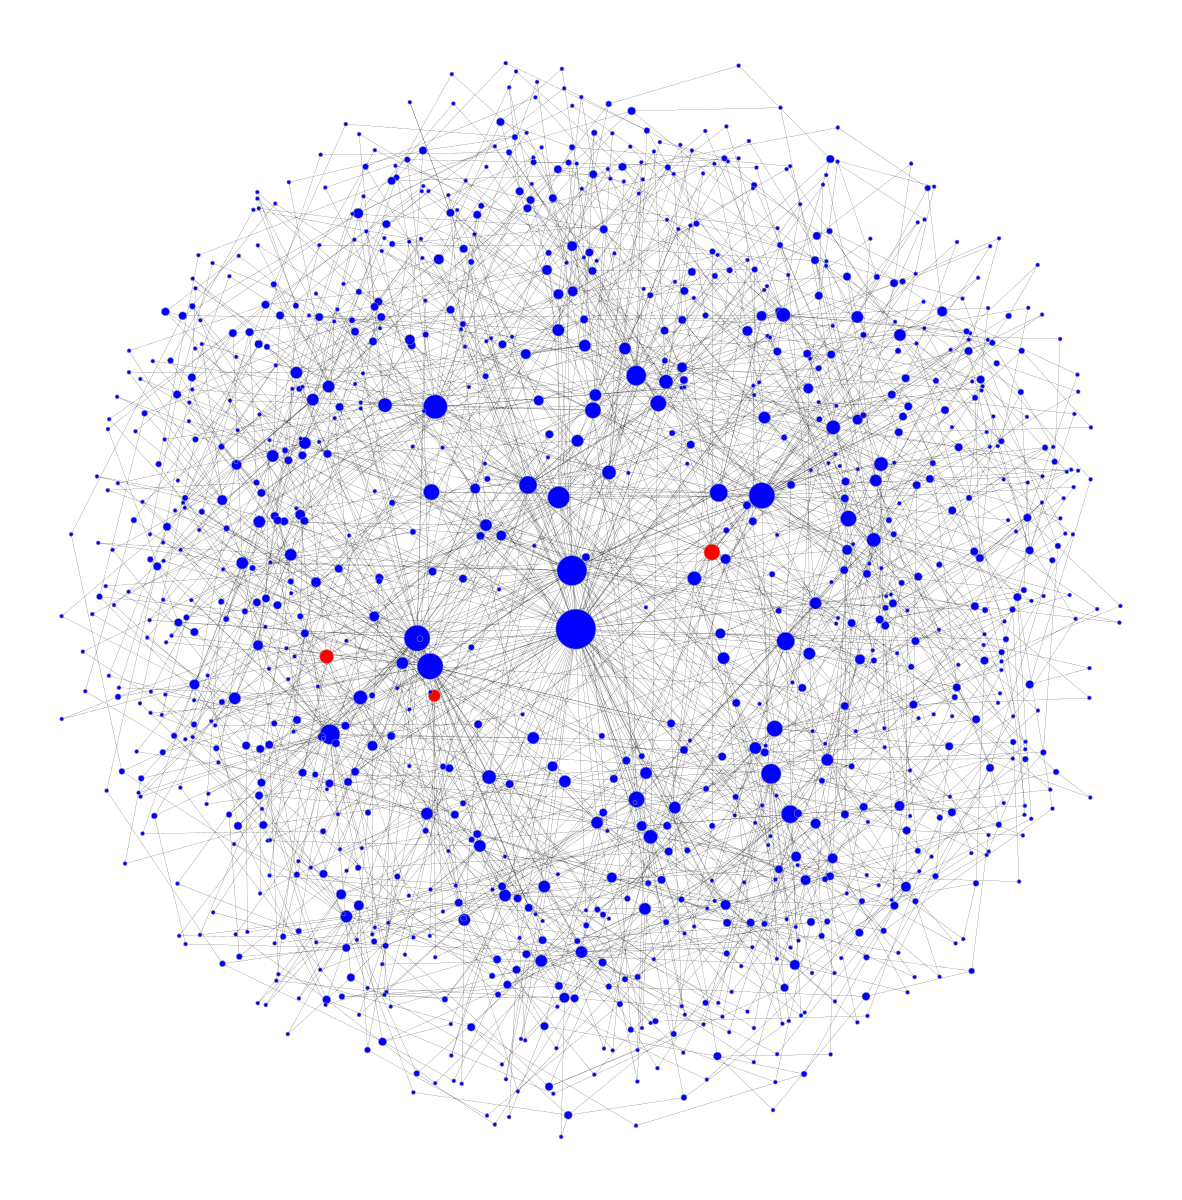

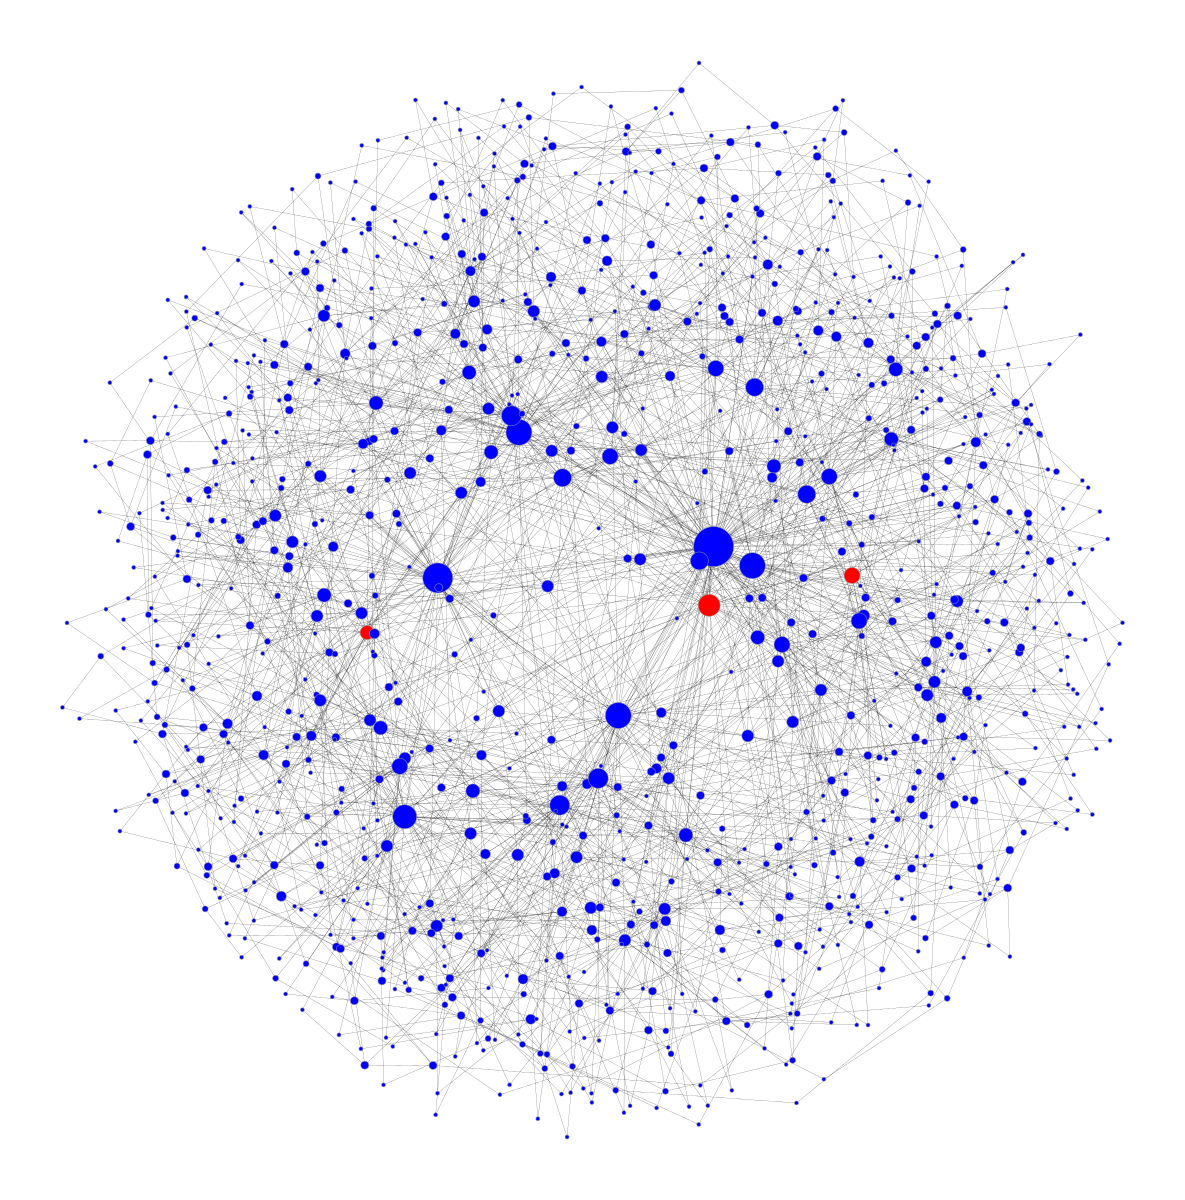

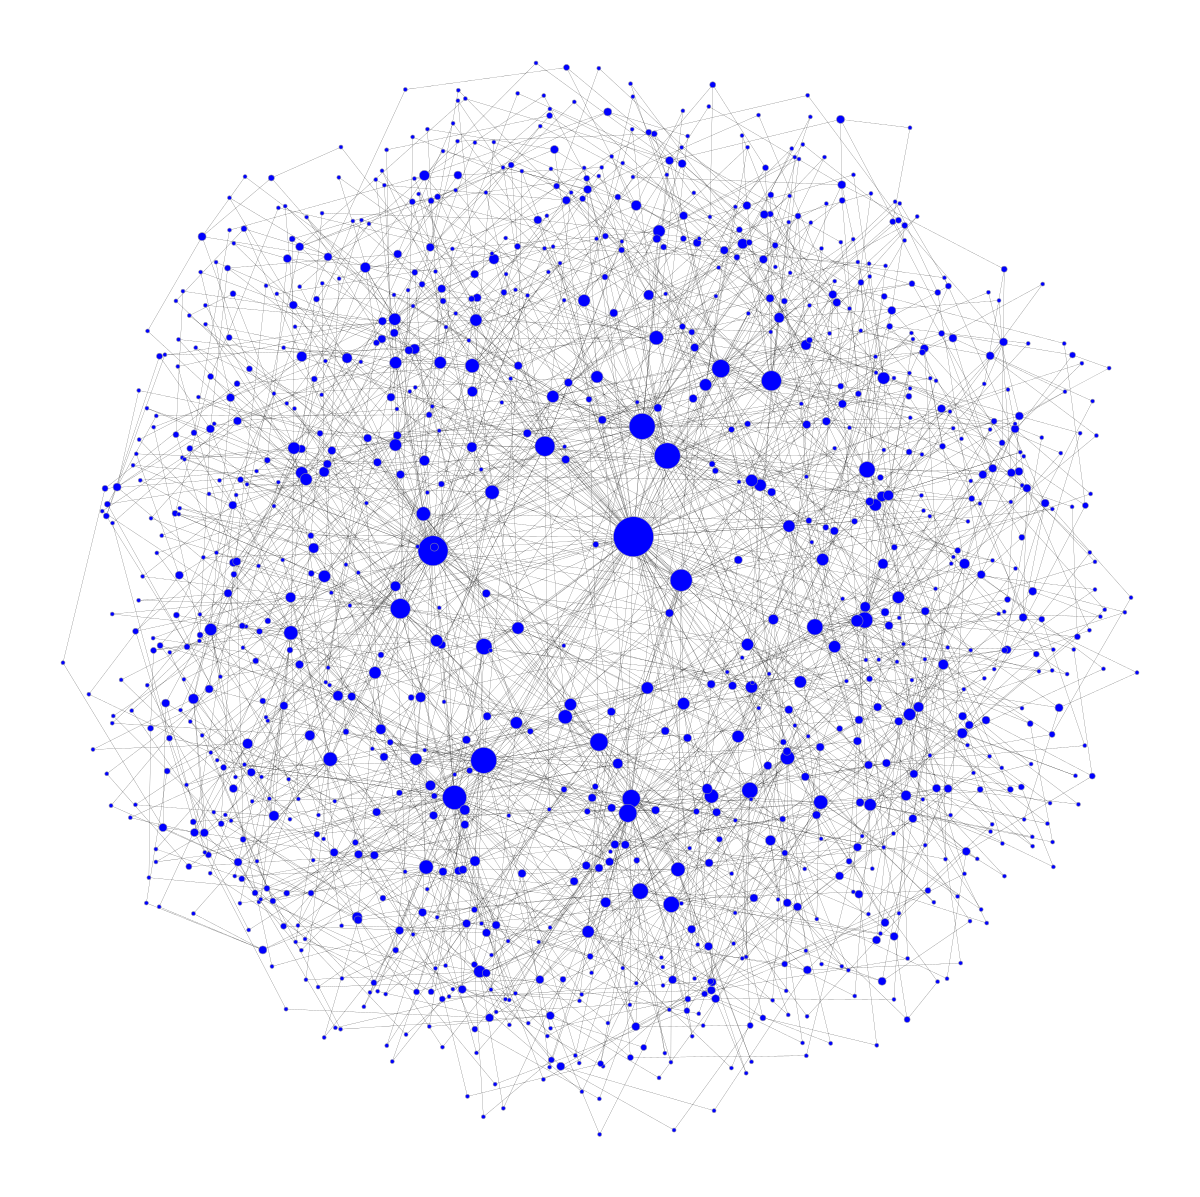

In [0]:
active = g.new_vertex_property("vector<double>")
for step in layer_i_nodes:
    for node in g.vertices():
        if node in step:
            active[node] = (1,0,0,1)
        else:
            active[node] = (0,0,1,1)
    draw_graph(g, vertex_fill_color=active)